In [1]:
# invoke some initial libraries that we want as part of this setup
import matplotlib.pylab as plt
import numpy as np
import MDAnalysis as mdanal
import pyemma.coordinates as coor

%matplotlib inline

In [2]:
def getCoordinates(pdbFileName, trjFileName):
    u = mdanal.Universe(pdbFileName, trjFileName, permissive=False)
    frames = []
    Ca = u.select_atoms('name CA')    
    for ts in u.trajectory[::]:
        frames.append(Ca.positions.T);
    return np.array(frames);

In [3]:
trajfile = '/home/akash/BPTI/BPTI Data/bpti_ca_1ms_dt10ns_aligned.xtc'
topfile = '/home/akash/BPTI/BPTI Data/bpti_ca.pdb'

In [4]:
coords = getCoordinates(topfile, trajfile)

/home/akash/.local/lib/python2.7/site-packages/MDAnalysis/lib/mdamath.py:152: RuntimeWarning: invalid value encountered in float_scalars
  angle = np.arccos(np.dot(a, b) / (norm(a) * norm(b)))


In [5]:
plt.style.use('ggplot')

In [6]:
print coords.shape

(412497, 3, 58)


In [7]:
import IterativeMeansAlign
iterAlign = IterativeMeansAlign.IterativeMeansAlign();
[itr, avgCoordsAll, eRMSDAll, newCoordsAll] = iterAlign.iterativeMeans(coords, 0.001, 5);

No handlers could be found for logger "main.IterativeMeansAlign"


In [8]:
coordsAll = np.reshape(newCoordsAll, (len(newCoordsAll), 3*58)).T; 
avgCoordsAll = np.mean(coordsAll, 1); #print avgCoords;
tmpAll = np.reshape(np.tile(avgCoordsAll, 412497), (412497,3*58)).T; 
caDevsMDall = coordsAll - tmpAll;
print caDevsMDall.shape;

(174, 412497)


In [9]:
Nc = coords.shape[0]; # number of conformers in the simulation
dim = coords.shape[1]; # number of dimensions - usually 3
Na = coords.shape[2]; # number of atoms in the selection

In [10]:
import numpy
import scipy.stats
import mpld3

def getSmoothingWeights(dt, windowsize, halflife):
    tau = (halflife/dt)/ np.log(2) # half-life = 5000ns and time between 2 consecutive time frame = 25ns
    alpha = 1 - np.exp(-1/tau)
    s = 0;
    wt = np.zeros((windowsize,1));
    for i in range (0,windowsize):
        wt[i] = (alpha * np.exp(-(windowsize-i)/tau))/0.96499303
        s = s + wt[i];
    return wt;
 
def getInstantaenousKurtosis(caDevsMDall, dt, windowsize, halflife, perRes=True, smooth=False):
    kresVals = numpy.zeros((caDevsMDall.shape[0], caDevsMDall.shape[1]));
    kvals = numpy.zeros((caDevsMDall.shape[1],1));
    kresZscorevals = numpy.zeros((caDevsMDall.shape[0],caDevsMDall.shape[1]));
    krespvals = numpy.zeros((caDevsMDall.shape[0],caDevsMDall.shape[1]));
    
    kZscorevals =  numpy.zeros((caDevsMDall.shape[1],1));
    kpvals = numpy.zeros((caDevsMDall.shape[1],1));
    for i in range(0, caDevsMDall.shape[1] - windowsize):
        cc = caDevsMDall[:, i:i+windowsize];
        kresVals[:, i] = scipy.stats.kurtosis(cc, axis=1, fisher=False);
        kvals[i] = scipy.stats.kurtosis(cc, axis=1, fisher=False).mean();
        kresZscorevals[:,i],krespvals[:,i] = scipy.stats.kurtosistest(cc, axis=1, nan_policy='omit');  
    
    kZscorevals = numpy.mean(kresZscorevals, axis = 0);    
    kpvals = numpy.mean(krespvals, axis = 0);
    kZscore = kZscorevals.tolist();
    kpvalue = kpvals.tolist();
    
    c = numpy.zeros(caDevsMDall.shape[1]-windowsize);
    if not perRes and smooth:
        val = numpy.zeros((windowsize,1));
        wt = getSmoothingWeights(dt, windowsize, halflife);
        for i in range (0, caDevsMDall.shape[1]-windowsize):
            a = wt[0:windowsize];
            a = a.reshape(windowsize);
            b = kvals[i + windowsize:i:-1];
            b = b.reshape(windowsize);
            c[i] = np.dot(a,b);
        return c, kvals, kZscore, kpvalue;
    elif perRes:
        return kresVals, kvals, kresZscorevals, krespvals;
    else:
        return kvals;

In [11]:
[c, kvals, kZscore, kpvalue] = getInstantaenousKurtosis(caDevsMDall=caDevsMDall, dt=25, windowsize=500, halflife=5000, perRes=False, smooth=True)

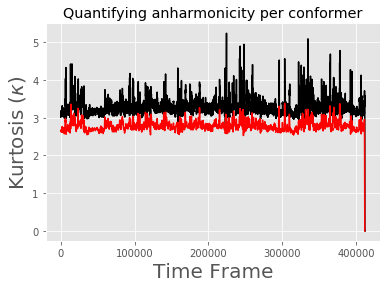

In [12]:
import matplotlib.ticker as ticker

ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(100000))

plt.title('Quantifying anharmonicity per conformer') 
plt.plot(kvals, 'k-'); 
plt.plot(c, 'r-');
plt.xlabel('Time Frame', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.show();

In [20]:
# Hover plot to display Z-score and pvalue for a conformer in the trajectory space specified by conformerSize parameter
import mpld3

conformerSize = 1000;

fig, ax = plt.subplots(figsize=(10,10))
ax.grid(color='white', linestyle='solid')
x = range(conformerSize);
lines = ax.plot(x,kvals[0:conformerSize], marker='o')
plt.title('Kurtosis Test: Zscore, pvalue calculation on per-conformer basis')
plt.xlabel('Time Frame', fontsize=20);
plt.ylabel('Kurtosis ($\kappa$)', fontsize=20);
plt.grid(True);
plt.legend();

labels = ['Zscore: {}, pvalue: {}'.format(i,j) for i,j in zip(kZscore[0:conformerSize],kpvalue[0:conformerSize])];
mpld3.plugins.connect(fig, mpld3.plugins.PointClickableHTMLTooltip(lines[0],labels=labels))
mpld3.display()

In [14]:
import numpy as np
import pandas as pd
rd = pd.DataFrame(kvals)
median = pd.DataFrame({'median':rd.median()})

threshold = 1.5
val = median + threshold
print val

     median
0  4.745389


In [15]:
hkurt = np.where(kvals>4.742007)[0]
np.savetxt('high-kurtosis.txt',hkurt,delimiter=',')

In [16]:
# function to get consecutive numbers as a separate list

def events(vals, step = 1):
    
    run = []
    result = [run]
    expect = None
    for v in vals:
        if(v == expect) or (expect is None):
            run.append(v)
        else:
            run = [v]
            result.append(run)
        expect = v + step
    
    return result

In [17]:
# array has list of events with window size = 500
array = events(hkurt)
array = np.asarray(array)